# Model Explanation Binary

## Dataset & Model Loading

In [6]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.w2v_feature_extraction import W2VTransformer
from utils.text_preprocessing import preprocess_text
shap.initjs()

df_train = pd.read_csv("../dataset/training_set.csv")  
df_train = df_train[['text', 'binary_label']]
df_train = df_train[
    df_train['text'].notna() & df_train['text'].str.strip().astype(bool)
]
model1 = Word2Vec.load("../model/word2vec_model1.model")

X_text = df_train["text"].fillna("").astype(str)
y_binary = df_train["binary_label"].map({
    "cyberbullying": 1,
    "not_cyberbullying": 0
})
       
pipeline_binary = joblib.load("../model/binary/LogisticRegression_BoW.pkl")

lr_binary = pipeline_binary.named_steps["model"]          

BoW_vectorizer_binary = pipeline_binary.named_steps["vectorizer"]

vocab = BoW_vectorizer_binary.get_feature_names_out()

print("\nBinary pipeline steps:")
print(pipeline_binary.steps)
print("\nExtracted model types:")
print("Binary model:   ", type(lr_binary))
print("Binary vocab size:   ", len(BoW_vectorizer_binary.get_feature_names_out()))



Binary pipeline steps:
[('preprocessing', TextPreprocessor()), ('vectorizer', CountVectorizer(max_features=350)), ('smote', SMOTE(random_state=42)), ('model', LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000))]

Extracted model types:
Binary model:    <class 'sklearn.linear_model._logistic.LogisticRegression'>
Binary vocab size:    350


## Local Binary Model Explanation

0    fuck bad idea say terribl lie alli see
Name: text, dtype: object
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0    realli hope bulli gay school
Name: original_text, dtype: object
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
feature correcly labeled

=== SHAP Explanation ===
SHAP prediction (sum): 0.8144
Model predicted proba (class 1): 0.8144
True class:(age)
Text preview: Really hope they bully the gay out of him at school....



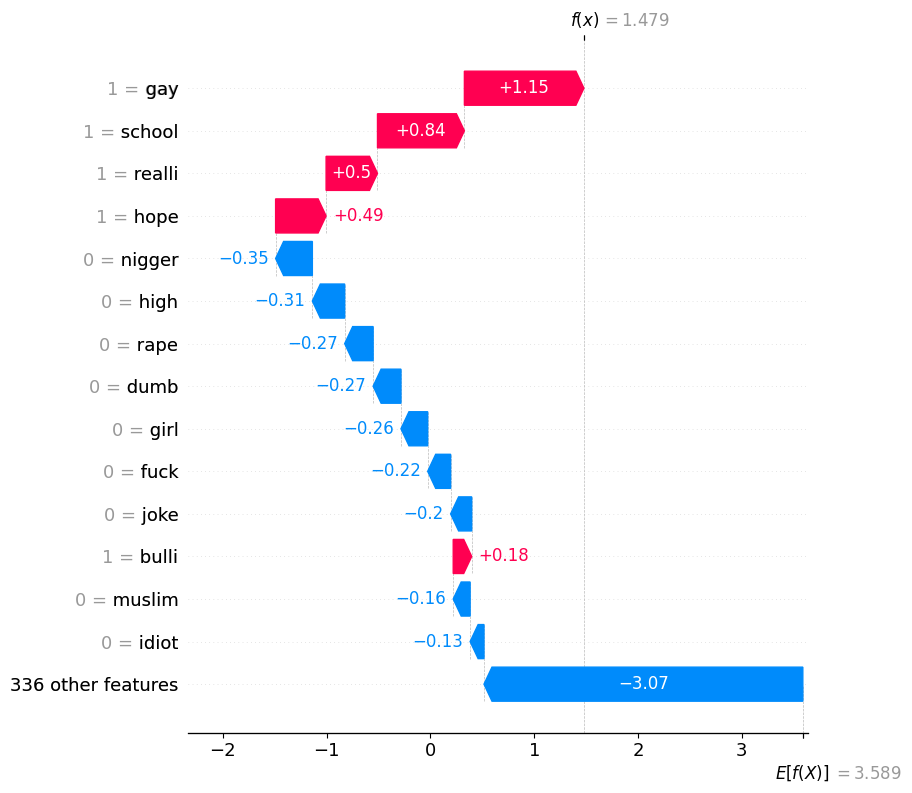


=== SHAP Explanation ===
SHAP prediction (sum): 0.9695
Model predicted proba (class 1): 0.9695
True class:(ethnicity)
Text preview: dumb niggers fuck all of u...



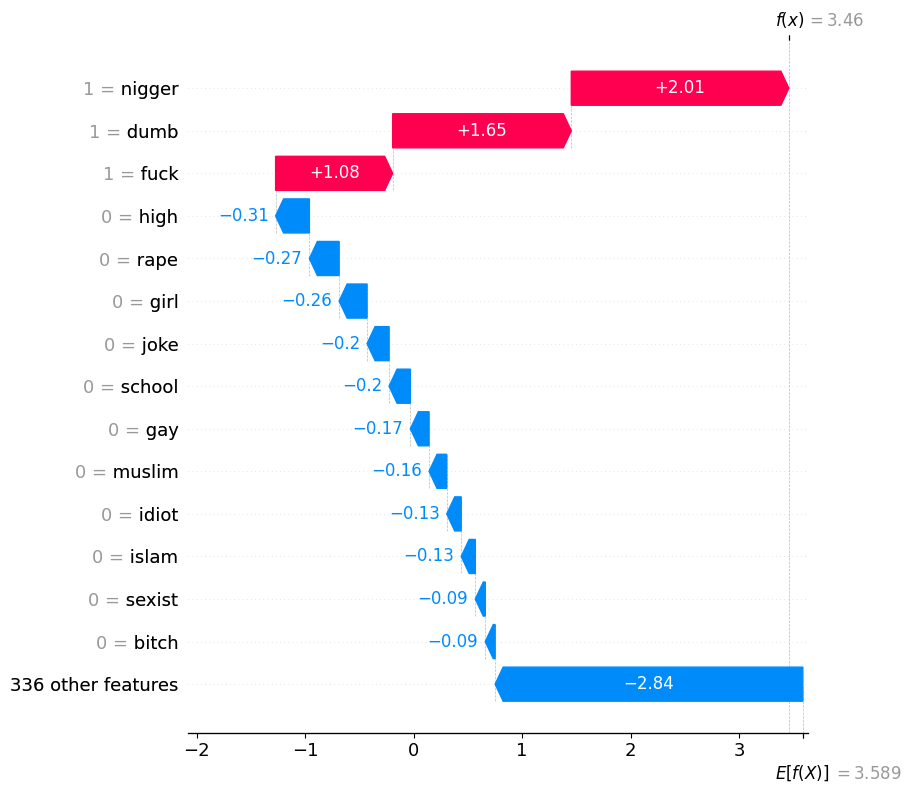


=== SHAP Explanation ===
SHAP prediction (sum): 0.9745
Model predicted proba (class 1): 0.9745
True class:(gender)
Text preview: RT @ConnellyBock Im not sexist but I hate woman sports commentators...



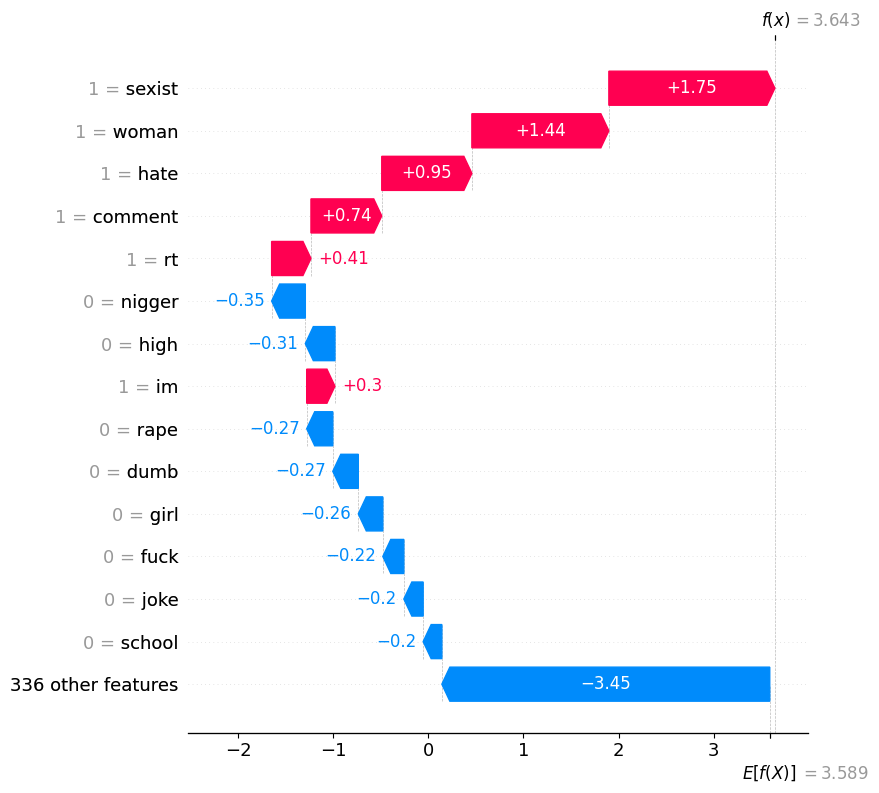


=== SHAP Explanation ===
SHAP prediction (sum): 0.7181
Model predicted proba (class 1): 0.7181
True class:(other_cyberbullying)
Text preview: @justinbieber plz follow us back, u helped Maja through the hard times in her life.. like bullying, and cutting. read her story in our bio10...



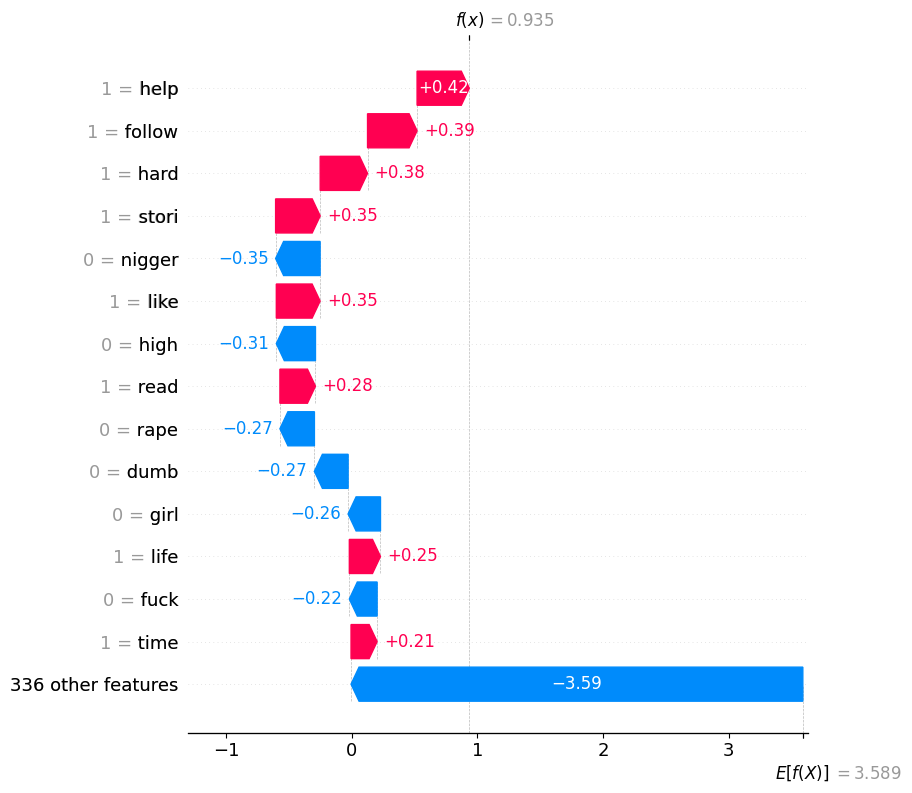


=== SHAP Explanation ===
SHAP prediction (sum): 0.9999
Model predicted proba (class 1): 0.9999
True class:(religion)
Text preview: You should visit a Muslim country and see how WOKE they are, right before you're beheaded like the 2 British girl idiots who thought vacationing in Mo...



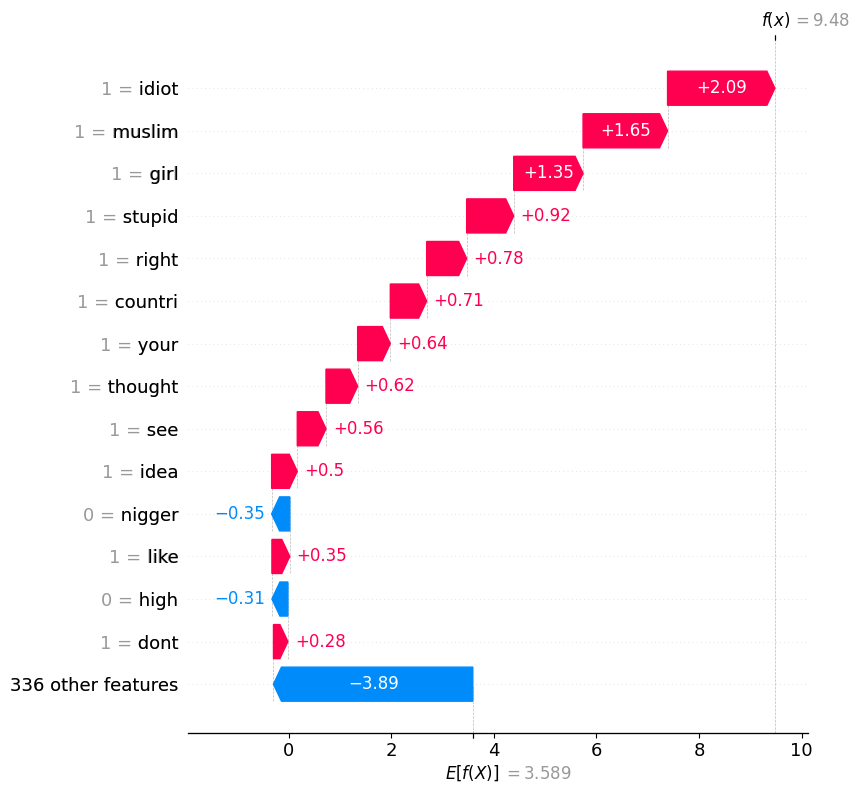


=== SHAP Explanation ===
SHAP prediction (sum): 0.3552
Model predicted proba (class 1): 0.3552
True class:(not_cyberbullying)
Text preview: The fact that i just paid $7 for a fruit cup and a coffee at school is insane...



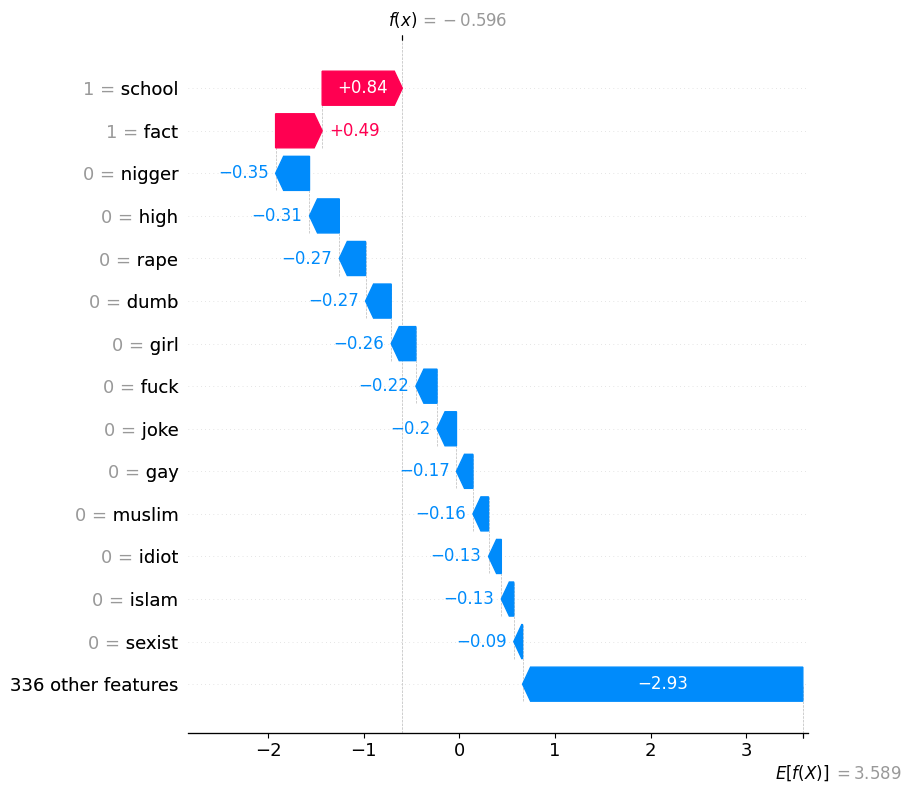

In [9]:


X_train = X_text.apply(preprocess_text)
print(X_train.head(1))
X_train= BoW_vectorizer_binary.transform(X_train).toarray().astype("float32")
print(X_train)

test = pd.read_csv("../dataset/selected_explanable_example.csv")
X_test = test["original_text"].apply(preprocess_text)
print(X_test.head(1))
X_test= BoW_vectorizer_binary.transform(X_test).toarray().astype("float32")
print(X_test)

explainer = shap.Explainer(lr_binary, X_train) 
shap_values = explainer(X_test)

if len(vocab) == shap_values.shape[1]:   
    shap_values.feature_names = list(vocab)
    print("feature correcly labeled")
else:
    raise Exception("something goes wrong")
for i in range(len(test)):
    label_id = test.loc[i, "label_id"]
    label_name = test.loc[i, "label_name"]
    text = test.loc[i, "original_text"]
    proba = lr_binary.predict_proba(X_test[i].reshape(1, -1))[0, 1]
    logit_shap = explainer.expected_value + shap_values[i].values.sum()
    proba_shap = 1 / (1 + np.exp(-logit_shap))

    print(f"\n=== SHAP Explanation ===")
    print(f"SHAP prediction (sum): {proba_shap:.4f}")
    print(f"Model predicted proba (class 1): {proba:.4f}")
    print(f"True class:({label_name})")
    print(f"Text preview: {text[:150]}...\n")
    shap.plots.waterfall(shap_values[i], max_display=15, show=False)
    plt.savefig(f"../SHAP/waterfall_plot_{label_name}.png", bbox_inches="tight", dpi=300)
    plt.close()
    shap.plots.waterfall(shap_values[i], max_display=15)


## Global Binary Model Explanation


In [8]:
coeffs = lr_binary.coef_[0] 
vocab = BoW_vectorizer_binary.get_feature_names_out()
important_words = sorted(zip(vocab, coeffs), key=lambda x: abs(x[1]), reverse=True)

top_n = 350
top_features = important_words[:top_n]

count_cyber = sum(1 for _, w in top_features if w > 0)
count_not = sum(1 for _, w in top_features if w < 0)

print(f"\nTop {top_n} Feature Count:")
print(f" - cyberbullying      : {count_cyber}")
print(f" - not_cyberbullying  : {count_not}")

print("Top Feature Model\n")
for word, weight in important_words[:350]:
    direction = "cyberbullying" if weight > 0 else "not_cyberbullying"
    print(f"{word:<20} : {weight:+.4f} ({direction})")


Top 350 Feature Count:
 - cyberbullying      : 342
 - not_cyberbullying  : 8
Top Feature Model

feminazi             : +3.2106 (cyberbullying)
nigger               : +2.3603 (cyberbullying)
bitch                : +2.2769 (cyberbullying)
idiot                : +2.2264 (cyberbullying)
rape                 : +1.9595 (cyberbullying)
high                 : +1.9466 (cyberbullying)
terror               : +1.9163 (cyberbullying)
dumb                 : +1.9154 (cyberbullying)
sexist               : +1.8369 (cyberbullying)
muslim               : +1.8109 (cyberbullying)
joke                 : +1.6923 (cyberbullying)
ur                   : +1.6436 (cyberbullying)
girl                 : +1.6098 (cyberbullying)
woman                : +1.4545 (cyberbullying)
middl                : +1.3836 (cyberbullying)
racism               : +1.3640 (cyberbullying)
terrorist            : +1.3473 (cyberbullying)
gay                  : +1.3240 (cyberbullying)
femal                : +1.3070 (cyberbullying)
islam     